<h1 align="center">Predicting Question Tags using Machine Learning</h1>

![](https://cdn-images-1.medium.com/max/1200/1*rEQGD7eciTUkoaePqyqY2A.png)

# Introduction:

Stack Overflow is the most popular question-answer site among programmers. Whenever a programmer finds themselves at a dead end, most of the times Stack Overflow is a one stop solution to all their problems. It's a very sophisticated and beautiful site. 

The questions on it are segregated into multiple topics. This is done by assigning one or more labels, known as a "Tag" to each question. If you have ever asked a question on SO, you'd know that the site automatically suggests the appropriate tags for your question.

![](https://i.stack.imgur.com/gbxst.jpg)

For example, if you ask -

> How to declare a variable in Python?

The tag `python` will be suggested to you. This is done using Natural Language Processing and Machine Learning.


## Objective:

The goal of this study is to analyze the questions on Stack Overflow, and predict appropriate tags for them.

## Data:

We will be using [this](https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data) huge repository of Stack Overflow Questions and Tags published on Kaggle by Facebook for a Kaggle competition. It's a zip file which yields a humongous `.csv` file of ~7 GB. There are 4 fields in this file.

        1. Id: question number
        2. Title: Title of the question 
        3. Body: text matter of the question
        4. Tags: A ' ' separated list of tags assigned to the question

Let's begin the journey by importing the libraries we need.


In [59]:
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import gensim
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Set figure parameters

In [3]:
rcParams['figure.figsize'] = (15,5)
plt.style.use('bmh')

Load the extracted csv file

In [5]:
#path = r'D:\data_science\datasets\stack overflow Tags\Train.csv'
#path = 'Train_deDuped.csv'
#path = 'Train_500k_cleaned.csv'
#df = pd.read_csv(path, nrows=500000)

path = 'Train.csv'
df = pd.read_csv(path)

Let's see what our data looks like

In [7]:
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


There are about 6 million records

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
Id       int64
Title    object
Body     object
Tags     object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


## Are there any duplicates in the dataframe?

If a combination of `Title`, `Body` and `Tags` is repeated, these are clearly duplicate values. There's no point in having them more than once.
 
Let's create a boolean list of all the duplicate rows.

In [9]:
duplicated = df.duplicated(subset=['Title', 'Body','Tags']) == True

There are `1827881` duplicate rows!

In [10]:
df[duplicated].shape

(1827881, 4)

Let's drop these records

In [11]:
df.drop_duplicates(subset=['Title','Body', 'Tags'], inplace=True)

After dropping duplicates, we have about ~70% of data

In [12]:
df.shape[0] / 6034195  * 100

69.70795607367677

Save the deplicated dataframe to disk

In [13]:
# df.to_csv('Train_deDuped.csv', index=False)

## Exploratory Data Analysis (EDA)

Any data science or machine learning project should begin with EDA. It gives us a *feel* of the data and helps us decide what features to include in the ML models. Let's analyze the four features in our data one by one. 

### 1. Feature: Tags

Each question in the dataframe has a space separated list of Tags associated with it. This is what we want to predict as accurately as possible. Let's define certain variables that will help us analyze how the Tags are distributed in the data.

In [14]:
# create a list of tags for each Question. 1 list for 1 question. Therefore a list of lists.
list_of_lists_tags = [str(tags).split() for tags in df['Tags'].values.tolist()]

# join all lists together to form a single list
all_tags = list(itertools.chain.from_iterable(list_of_lists_tags))

tag_counts = Counter()

for tag in all_tags:
    tag_counts[tag] += 1

# Get unique tags
all_tags = list(set(all_tags))

df_tag_counts = pd.DataFrame.from_dict(tag_counts, orient='index')

A dataframe with index as tag name and column as count

In [17]:
df_tag_counts.head(10)

,0
php,284103
image-processing,7099
file-upload,6807
upload,4281
mime-types,966
firefox,14066
r,20096
matlab,13532
machine-learning,2141
c#,331505


### How many unique tags?

In [18]:
print('There are {} unique tags in the data.'.format(len(all_tags)))

There are 42048 unique tags in the data.


### Most common Tags

Following are the 15 most common tags found in the dataset. Looks like `C#` is the most popular language among the developers around the world.

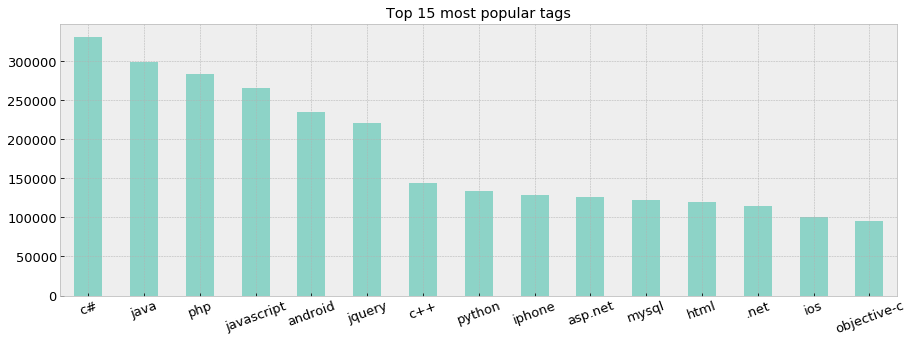

In [19]:
_ = df_tag_counts.sort_values(by=0, ascending=False)[:15].plot(kind='bar', rot=20, cmap='Set3', legend=False)
_.tick_params(axis='x', labelsize=13)
_.tick_params(axis='y', labelsize=13)
_ = plt.title('Top 15 most popular tags')

## Wordcloud of Tags

Wordcloud is a pictorial representation of how the words are distributed in a corpus. The most frequent words are shown in the biggest font, with sizes decreasing correspondingly with decrease in frequency.

In [20]:
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(dict(tag_counts.most_common()))

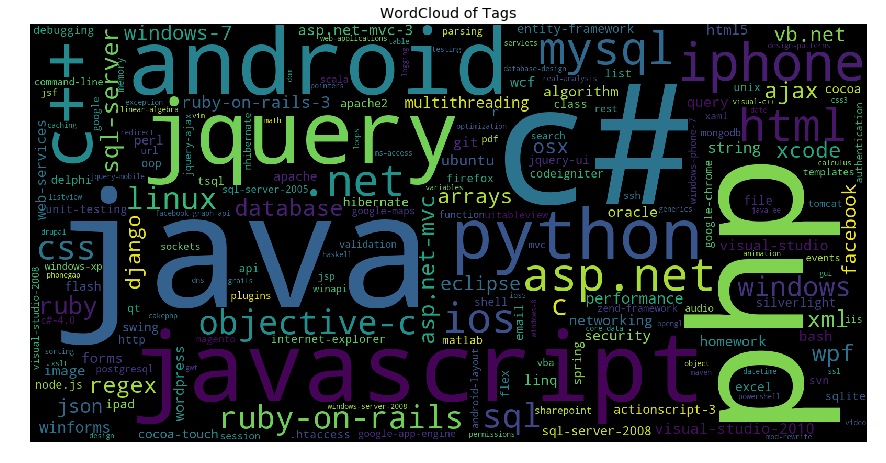

In [22]:
plt.figure(figsize=(15,9))
plt.axis('off')
plt.title('WordCloud of Tags')
plt.imshow(wordcloud)
plt.show()

## Frequency of Tags

We have 42048 tags, are they evenly distributed? Nope!

Look at the graph below and observe that a few hundred tags cover most of the questions while the others are encountered sporadically.

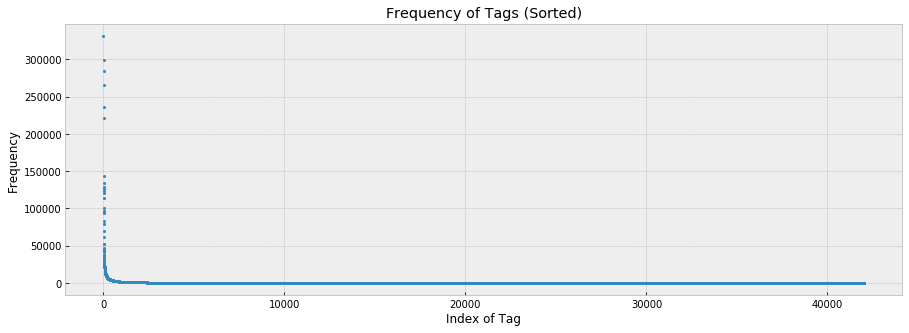

In [23]:
frequency_of_tags_sorted = sorted(list(tag_counts.values()))[::-1]

plt.plot(frequency_of_tags_sorted, marker = '.', linestyle='none', markersize='4')
plt.title('Frequency of Tags (Sorted)')
plt.xlabel('Index of Tag')
plt.ylabel('Frequency')
plt.show()

### How many Tags are there which cover most of the questions?

In this section, we'll try to see exactly how many tags are there which are associated with most of the questions? Let's define a function to plot the Cumulative Distribution Function.

In [24]:
def cdf(data):
    """
    compute ECDF for a one dimensional array of measurements.
    The y data of the ECDF go from 1/n to 1 in equally spaced increments.
    the end value in np.arange() is not inclusive. Therefore, np.arange() will need to go from 1 to n+1
    """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1) / n
    return x,y

Looking at the CDF of Tag Frequency, we find that about 99% of the questions can be covered with a few hundred tags. But exactly what is this number? We'll find it out next. 

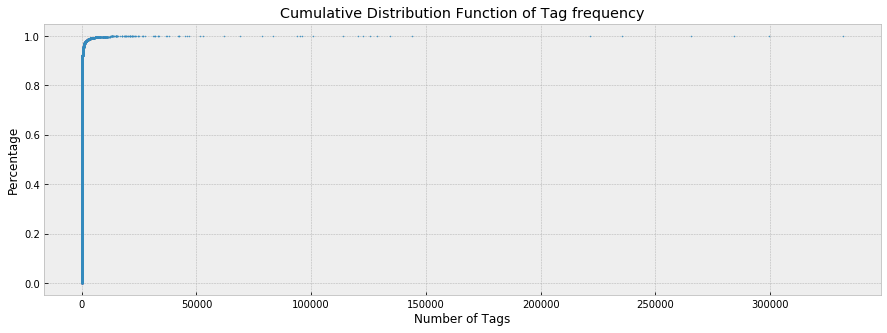

In [26]:
x,y = cdf(frequency_of_tags_sorted)
plt.plot(x,y, marker='.', linestyle='none', markersize='1')
plt.title('Cumulative Distribution Function of Tag frequency')
plt.xlabel('Number of Tags')
plt.ylabel('Percentage')
plt.show()

## Explained Questions by n tags

The following block of code prints the percentage of questions covered by the top `n` Tags. By varying the value of n, let's do some analysis.

In [29]:
N = []
pct_of_questions = []

for n in range(50, 1550, 50):
    # n = 100
    top_n_tags_SET = set(dict(tag_counts.most_common(n)).keys())
    no_of_questions_covered = 0

    for tags in list_of_lists_tags:

         if bool(top_n_tags_SET.intersection(set(tags))) is True:
                no_of_questions_covered += 1
    
    pct = no_of_questions_covered/len(list_of_lists_tags)*100
    
    N.append(n)
    pct_of_questions.append(pct)
    
    print('Questions covered by top',n,'Tags:',np.round(pct, 2), '%')        

Questions covered by top 50 Tags: 68.54 %
Questions covered by top 100 Tags: 76.49 %
Questions covered by top 150 Tags: 80.19 %
Questions covered by top 200 Tags: 83.15 %
Questions covered by top 250 Tags: 84.88 %
Questions covered by top 300 Tags: 86.25 %
Questions covered by top 350 Tags: 87.37 %
Questions covered by top 400 Tags: 88.4 %
Questions covered by top 450 Tags: 89.27 %
Questions covered by top 500 Tags: 90.05 %
Questions covered by top 550 Tags: 90.75 %
Questions covered by top 600 Tags: 91.22 %
Questions covered by top 650 Tags: 91.76 %
Questions covered by top 700 Tags: 92.13 %
Questions covered by top 750 Tags: 92.47 %
Questions covered by top 800 Tags: 92.89 %
Questions covered by top 850 Tags: 93.32 %
Questions covered by top 900 Tags: 93.69 %
Questions covered by top 950 Tags: 93.93 %
Questions covered by top 1000 Tags: 94.16 %
Questions covered by top 1050 Tags: 94.36 %
Questions covered by top 1100 Tags: 94.55 %
Questions covered by top 1150 Tags: 94.7 %
Questions 

Plot the above result

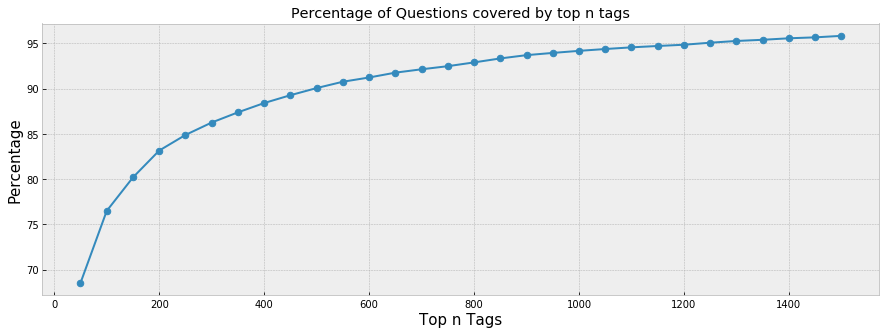

In [30]:
plt.plot(N, pct_of_questions, marker='.', markersize=13)
plt.xlabel('Top n Tags', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.title('Percentage of Questions covered by top n tags')
plt.show()

As is evident in the graph above, the top 500 tags appear in about 90% of the questions, while the top 300 appear in 85% of the questions.

As this is a prototype solution, in order to reduce the complexity of the problem, it is necessary that we choose a small subset of the tags. Training a multi-label classification model on 42,048 features will require huge compute power and attempting do it is just not feasible for this study. Therefore, I'll limit the number of tags to 300.

## Tags per question

How many tags does a question have typically?

In [31]:
number_of_tags = Counter()

for tags in list_of_lists_tags:
    
    number_of_tags[len(tags)] += 1

In [32]:
number_of_tags

Counter({5: 505158, 1: 568297, 3: 1206157, 2: 1111706, 4: 814996})

Observe the graph below and notice that most of the questions have three tags.

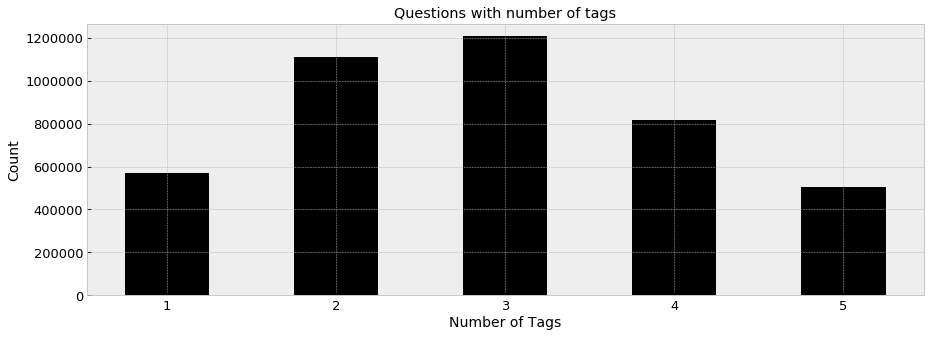

In [33]:
x = number_of_tags.keys()
y= number_of_tags.values()
plt.bar(x,y, width=0.5, color='k')
plt.title('Questions with number of tags')
plt.xlabel('Number of Tags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### 2. Feature: Body

Following are a few examples of unprocessed text in the body of a few questions. As you can observe, this data is really dirty from a data analysis perspective. We need to massage it into a format fit for generating vectors, which will in turn be used for training ML models.

In [39]:
for question in df['Body'].sample(3):
    print(question, end='\n*************************************************************************************\n')

<p>Why is installing MySQL on Windows Vista such a bear?  For someone who is not 
a professional database administrator, it seems like I am jumping through hoops.</p>

<p>This page
<a href="http://forums.mysql.com/read.php?11,200958,204223#REPLY" rel="nofollow">http://forums.mysql.com/read.php?11,200958,204223#REPLY</a>
pointed to this page
<a href="http://www.sqlservercentral.com/blogs/brian_kelley/archive/2008/04/04/installing-5-0-51a-mysql-community-edition-on-windows-vista.aspx" rel="nofollow">http://www.sqlservercentral.com/blogs/brian_kelley/archive/2008/04/04/installing-5-0-51a-mysql-community-edition-on-windows-vista.aspx</a>
which suggests this page
<a href="http://port25.technet.com/archive/2007/03/16/mysql-on-windows-configuration-install.aspx" rel="nofollow">http://port25.technet.com/archive/2007/03/16/mysql-on-windows-configuration-install.aspx</a>
which points to this beautiful pdf file
<a href="http://port25.technet.com/videos/research/MySQL_Windows.pdf" rel="nofollow">h

### Clean the dataframe

The following function takes in a corpus of text, and removes `HTML` from it.

In [40]:
def stripHTML(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

Function that cleans the input text by removing HTML tags, code or special characters.

In [13]:
def clean_text(row):
    row = re.sub('<code>(.*?)</code>', '', row)
    row = stripHTML(row.encode('utf-8'))
    row = re.sub(r'[^A-Za-z]+', ' ', row)
    words = word_tokenize(row.lower())
    row = ' '.join(str(stemmer.stem(j))\
                          for j in words \
                              if j not in stop_words and (j=='c' or len(j)>2))
    return row

In [41]:
#df.drop(axis=1, labels='title_plus_body', inplace=True)
df.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

### More importance to the Title

The title of a question is often sufficient to determine what tags are applicable to it. Therefore, it makes sense to give it more importance as compared to the body of the question. How do we do this?

By creating a new column `title_plus_body` that repeats the title of the question 3 times. This is a simple hack that will give three times more importance to the title of the question, when we convert the textual data into vectors using `Tfidf` or `Bag of Words`.

In [43]:
df['title_plus_body'] = df.Title + ' ' + df.Title + ' ' + df.Title + ' ' + df.Body

As expected, the new column is added to the dataframe. It is a concatenation of three times title and the body.

In [44]:
df.head()

,Id,Title,Body,Tags,title_plus_body
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,How to check if an uploaded file is an image w...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,How can I prevent firefox from closing when I ...
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,R Error Invalid type (list) for variable R Err...
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,How do I replace special characters in a URL? ...
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,How to modify whois contact details? How to mo...


This is how the new column looks before it is cleaned.

In [12]:
df.title_plus_body.loc[3]

'How do I replace special characters in a URL? How do I replace special characters in a URL? How do I replace special characters in a URL? <p>This is probably very simple, but I simply cannot find the answer myself :( </p>\n\n<p>Basicaly, what I want is, given this string:</p>\n\n<p>"http://www.google.com/search?hl=en&amp;q=c# objects"</p>\n\n<p>I want this output:</p>\n\n<p><a href="http://www.google.com/search?hl=en&amp;q=c%23+objects">http://www.google.com/search?hl=en&amp;q=c%23+objects</a></p>\n\n<p>I\'m sure there\'s some helper class somewhere buried in the Framework that takes care of that for me, but I\'m having trouble finding it.</p>\n\n<p>EDIT: I should add, that this is for a Winforms App.</p>\n'

Clean the dataframe using the functions we defined above.

In [ ]:
%%notify
%%time

stop_words = set(stopwords.words('english'))

# Add `num` to stopwords
stop_words.add('num')
stop_words.add('na')
stop_words.add('like')
stop_words.add('could')
stop_words.add('would')
stop_words.add('should')
stop_words.add('thank')
stop_words.add('think')
stop_words.add('need')
stop_words.add('know')

stemmer = SnowballStemmer("english")

df['title_plus_body'] = df.title_plus_body.apply(clean_text)

This is how the text looks after cleaning

In [6]:
df.title_plus_body.loc[3]

'replac special charact url replac special charact url replac special charact url probabl simpl simpli find answer basicali want given string http com search amp c object want output http com search amp c object sure helper class somewher buri framework take care troubl find edit add winform app'

In [45]:
df.columns

Index(['Id', 'Title', 'Body', 'Tags', 'title_plus_body'], dtype='object')

As we discussed above, the total number of tags in the data is `42048`, which is a huge number! The multilabel classification algorithms would take days to finish training. Therefore we need to select a subset of the tags that cover as many questions as possible.

## Limit the data

We will work with 500k questions instead of all 6 million. Therefore, let's see how many tags sufficiently cover these 500k questions. I've saved the top 500k cleaned questions on disk, with only the columns `title_plus_body` and `Tags`, since the operation takes a lot of time. 

In [4]:
path = 'Train_500k_cleaned.csv'
df = pd.read_csv(path)
df.head()

,title_plus_body,Tags
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl prevent firef...,firefox
2,error invalid type list variabl error invalid ...,r matlab machine-learning
3,replac special charact url replac special char...,c# url encoding
4,modifi whoi contact detail modifi whoi contact...,php api file-get-contents


In [5]:
df.shape

(500000, 2)

In [6]:
# create a list of tags for each Question. 1 list for 1 question. Therefore a list of lists.
list_of_lists_tags = [str(tags).split() for tags in df['Tags'].values.tolist()]

# join all lists together to form a single list
all_tags = list(itertools.chain.from_iterable(list_of_lists_tags))

tag_counts = Counter()

for tag in all_tags:
    tag_counts[tag] += 1

# Get unique tags
all_tags = list(set(all_tags))

df_tag_counts = pd.DataFrame.from_dict(tag_counts, orient='index')

In [7]:
N = []
pct_of_questions = []

print('*** Considering 500k Questions ***')

for n in range(50, 1550, 50):
    # n = 100
    top_n_tags_SET = set(dict(tag_counts.most_common(n)).keys())
    no_of_questions_covered = 0

    for tags in list_of_lists_tags:

         if bool(top_n_tags_SET.intersection(set(tags))) is True:
                no_of_questions_covered += 1
    
    pct = no_of_questions_covered/len(list_of_lists_tags)*100
    
    N.append(n)
    pct_of_questions.append(pct)
    
    print('Questions covered by top',n,'Tags:',np.round(pct, 2), '%')

*** Considering 500k Questions ***
Questions covered by top 50 Tags: 67.61 %
Questions covered by top 100 Tags: 75.43 %
Questions covered by top 150 Tags: 79.71 %
Questions covered by top 200 Tags: 82.41 %
Questions covered by top 250 Tags: 84.2 %
Questions covered by top 300 Tags: 85.71 %
Questions covered by top 350 Tags: 87.0 %
Questions covered by top 400 Tags: 88.26 %
Questions covered by top 450 Tags: 89.07 %
Questions covered by top 500 Tags: 89.78 %
Questions covered by top 550 Tags: 90.47 %
Questions covered by top 600 Tags: 91.01 %
Questions covered by top 650 Tags: 91.45 %
Questions covered by top 700 Tags: 91.87 %
Questions covered by top 750 Tags: 92.33 %
Questions covered by top 800 Tags: 92.78 %
Questions covered by top 850 Tags: 93.08 %
Questions covered by top 900 Tags: 93.37 %
Questions covered by top 950 Tags: 93.68 %
Questions covered by top 1000 Tags: 93.92 %
Questions covered by top 1050 Tags: 94.19 %
Questions covered by top 1100 Tags: 94.44 %
Questions covered b

We were hoping that a smaller number of tags covers maximum percent of these 500k questions. Unfortunately, it is not so. However, in order to keep the number of tags low to manage the computation complexity, let's limit the tags to 300 which cover about 86% of the questions.

## Target variable: Binary Bag of Words

The ML algorithms require target variables to be in shape `n_samples x n_labels` for multiclass problems.

Since we are interested only in whether the tag occues, this should be a binary indicator variable. This can be done using a `Binary Bag of Words` representation of the `Tags` feature in our data.

In [8]:
tag_vectorizer = CountVectorizer(max_features=300, min_df=20, binary=True)
tags_bow = tag_vectorizer.fit_transform(df['Tags'])

In [9]:
tags_bow

<500000x300 sparse matrix of type '<class 'numpy.int64'>'
	with 982933 stored elements in Compressed Sparse Row format>

## Train and Test sets: X & y

Since the original data is randomly distributed, we don't need to use the `train_test_split` function to split the data. Let's divide the train and test data in ratio 80:20.

In [10]:
split_upto = int(0.80*df.shape[0])

y_train = tags_bow[:split_upto]
y_test = tags_bow[split_upto:]

## X: Tfidf 1-grams

We'll first try a simple Tfidf representation of our question corpus.

In [11]:
split_upto = int(0.80*df.shape[0])

df_X_train = df['title_plus_body'][:split_upto]
df_X_test = df['title_plus_body'][split_upto:]

Limit max features to 20000, i.e. the top 20k features by Tfidf value will be considered.

In [12]:
text_vectorizer = TfidfVectorizer(min_df=20, max_features=20000)
X_train = text_vectorizer.fit_transform(df_X_train)
X_test = text_vectorizer.transform(df_X_test)

The shape of our train and test sets

In [13]:
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', y_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_test is:', y_test.shape)

The shape of X_train is: (400000, 20000)
The shape of y_train is: (400000, 300)
The shape of X_test is: (100000, 20000)
The shape of y_test is: (100000, 300)


### Function to show the question with actual and predicted tags

The following function will print the predicted as well as actual tags of 5 sample questions.

In [30]:
def compare_Tags(predictions, tag_vectorizer, df):
    
    x,y = predictions.nonzero()
    non_zero_tuples = list(zip(x, y))
    
    printed = 0
    
    #print(len(non_zero_tuples))
    
    for i in range(len(non_zero_tuples)):
        
        k = i
        predicted_tags_indexes = []

        question_no = non_zero_tuples[k][0]
        
        while True:
            
            #print('k=',k, end='|')
            
            if (k < len(non_zero_tuples)) and (non_zero_tuples[k][0] == question_no) :
         
                predicted_tags_indexes.append(non_zero_tuples[k][1])

                k += 1
            
            else:
                
                break
            
        i = k
        
        actual_tags = df.loc[question_no]['Tags'].split()
        
        if (printed < 5) and len(set(actual_tags).\
                intersection(set(tag_vectorizer.get_feature_names()[t]\
                                 for t in predicted_tags_indexes))) > 1:
        
            print('Question:\n{}\n'.format(df.loc[question_no]['title_plus_body']))
            print('Actual Tags:\n{}'.format(actual_tags))
            print('\nPredicted Tags:')

            for t in predicted_tags_indexes:

                print(tag_vectorizer.get_feature_names()[t], end = ' | ')
            print('\n--------------------------------------------------', end='\n\n')
            printed += 1

## Metrics to judge model's performance

* F1 score

It is defined as the Harmonic mean of Precision and Recall.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/057ffc6b4fa80dc1c0e1f2f1f6b598c38cdd7c23)

F1 is typically calculated in two ways: 
    - Micro Averaged F1 score 
    - Macro averaged F1 score

In case of imbalanced data, which our dataset is, we should prefer the micro averaged F1 score.

* Hamming Loss:

If $\hat{y}_j$ is the predicted value for the $j$-th label of a given sample, $y_j$ is the corresponding true value, and $n_\text{labels}$ is the number of classes or labels, then the Hamming loss $L_{Hamming}$ between two samples is defined as:

$$L_{Hamming}(y, \hat{y}) = \frac{1}{n_\text{labels}} \sum_{j=0}^{n_\text{labels} - 1} 1(\hat{y}_j \not= y_j)$$

Ref: [Micro F1 vs Macro F1](https://datascience.stackexchange.com/a/16001/37490)
, [Hamming Loss](https://scikit-learn.org/stable/modules/model_evaluation.html#hamming-loss)

## Model 1: Binary Relevance (Logistic Regression | 1-gram Tfidf X)

Let's try the Binary Relevance approach for multilabel classification using Logistic Regression.

### Binary Relevance

*In this strategy, we independently train one binary classifier for each label. Given an unseen sample, the combined model then predicts all labels for this sample for which the respective classifiers predict a positive result.*

We will also try to find the optimal value of the parameter C using GridSearch.

In [17]:
X_train.shape, y_train.shape

((400000, 20000), (400000, 300))

In [18]:
%%notify
%%time

base_estimator = LogisticRegression(solver='newton-cg')

OvsR_model = OneVsRestClassifier(base_estimator)

hyp_par = {
    
    "estimator__C" : [0.1, 0.5, 1.0]
}

clf = GridSearchCV(estimator=OvsR_model, cv=2,param_grid=hyp_par, verbose=True, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 51.6min remaining: 103.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 59.7min finished


CPU times: user 3h 41min 2s, sys: 24min 11s, total: 4h 5min 14s
Wall time: 2h 36min 51s


<IPython.core.display.Javascript object>

Best parameter

In [19]:
clf.best_params_

{'estimator__C': 1.0}

Predict the target labels on Test dataset

In [20]:
predictions = clf.predict(X_test)
x, y = predictions.nonzero()

Let's see how our first model has performed. We are particularly interested in the `micro averaged F1 score` and `Hamming Loss`.

In [21]:
print('***** Binary Relevance | Logistic Regression | 1-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))
print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Logistic Regression | 1-gram Tfidf ***** 

Accuracy: 0.28519
F1 Score(macro) 0.40142982112910575
F1 Score(micro) 0.5423841059602649
Precision (macro) 0.6438963860278104
Precision (micro) 0.7796510133559263
Recall (micro) 0.41583525003427213
Recall (macro) 0.3125850785245812
Hamming loss 0.004606666666666667


In [26]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['#', 'Approach', 'Model', 'Data', 'F1', 'Precision', 'HL']
table.add_row([1, 'Binary Relevance', 'Logistic Regression', '1-gram Tfidf', '0.54', '0.77', '0.004'])

### Sample Predictions | Binary Relevance , LR , Tfidf 1-gram

It's time to see the model in action. Recall that we defined a function that prints a few sample Tag predictions. Let's pass the model's `predictions` and the Tfidf vectorizer of Tags as parameters.

The printed question is in its cleaned form.

In [24]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax request particular element play jqueri load function grab particular div page result load ajax test html variabl work howev take forev respons still contain complet document even though return result div defin exampl variabl anoth way accomplish respons contain actual div fastest way return result clarifi search generat foreach loop page img name php echo product getid onclick event make ajax request relat div img click function result load ajax test html attr name page test html also foreach loop generat div block pass name david juan suggest sever side solut someon pleas explain bit

Actual Tags:
['php', 'javascript', 'jquery', 'ajax']

Predicted Tags:
javascript | jquery | php | 
--------------------------------------------------

Question:
ajax content load ajax content load ajax content load work browser nthe content dosn seem load site press menu item wor

## Model 2 : Binary Relevance (Linear SVC | 1-gram Tfidf X)

In [25]:
%%notify
%%time

base_estimator = LinearSVC()

OvsR_model = OneVsRestClassifier(base_estimator)

hyp_par = {
    
    "estimator__C" : [0.1, 0.5, 1.0]
}

clf = GridSearchCV(estimator=OvsR_model, cv=2,param_grid=hyp_par, verbose=True, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  8.1min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.6min finished


CPU times: user 14min 45s, sys: 3.13 s, total: 14min 48s
Wall time: 21min 3s


<IPython.core.display.Javascript object>

Best Parameters

In [26]:
clf.best_params_

{'estimator__C': 0.5}

In [27]:
predictions = clf.predict(X_test)
x, y = predictions.nonzero()

In [28]:
print('***** Binary Relevance | Linear SVC | 1-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))
print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Linear SVC | 1-gram Tfidf ***** 

Accuracy: 0.30105
F1 Score(macro) 0.4019936615589079
F1 Score(micro) 0.5580469022289347
Precision (macro) 0.6787553406433703
Precision (micro) 0.8058516757420048
Recall (micro) 0.42680233355165953
Recall (macro) 0.3228634902494693
Hamming loss 0.004438166666666667


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Store model's performance in a table

In [27]:
table.add_row([2, 'Binary Relevance', 'Linear SVC', '1-gram Tfidf', '0.55', '0.80', '0.004'])

### Sample Predictions | Binary Relevance , SVC , Tfidf 1-gram

In [31]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax request particular element play jqueri load function grab particular div page result load ajax test html variabl work howev take forev respons still contain complet document even though return result div defin exampl variabl anoth way accomplish respons contain actual div fastest way return result clarifi search generat foreach loop page img name php echo product getid onclick event make ajax request relat div img click function result load ajax test html attr name page test html also foreach loop generat div block pass name david juan suggest sever side solut someon pleas explain bit

Actual Tags:
['php', 'javascript', 'jquery', 'ajax']

Predicted Tags:
javascript | jquery | php | 
--------------------------------------------------

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax re

## Model 3: Classifier-Chain | Naive Bayes | 1-gram Tfidf X

### Classifier Chain

In this approach, the first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.

Let's try Naive Bayes using this method.

Ref: [Classifier Chain](https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/)

In [32]:
%%notify
%%time

classifier = ClassifierChain(
    classifier = MultinomialNB(alpha=0.1),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

CPU times: user 14min 20s, sys: 1min 40s, total: 16min
Wall time: 11min 28s


<IPython.core.display.Javascript object>

Predictions

In [33]:
predictions = classifier.predict(X_test)
x, y = predictions.nonzero()

In [34]:
print('***** Classifier Chain | Naive Bayes | 1-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))
print('Hamming loss',hamming_loss(y_test,predictions))

***** Classifier Chain | Naive Bayes | 1-gram Tfidf ***** 

Accuracy: 0.14993
F1 Score(macro) 0.22533229252345938
F1 Score(micro) 0.3248169205212793
Precision (macro) 0.30243909616980763
Precision (micro) 0.30120586486850043
Recall (micro) 0.3524444918330769
Recall (macro) 0.265396181699586
Hamming loss 0.009619333333333334


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Add the results to the table

In [28]:
table.add_row([3, 'Classifier Chain', 'Naive Bayes', '1-gram Tfidf', '0.32', '0.30', '0.009'])

### Sample Predictions | Classifier Chain , Naive Bayes , Tfidf 1-gram

In [35]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
creat block transit jqueri creat block transit jqueri creat block transit jqueri best way creat block transit jqueri plugin provid transit transit want imag galleri transit look someth http mitya script blockster transit effect diagon expand block transit http codecanyon net item jqueri banner rotat slideshow full screen preview problem first link slow use bit block figur transit creat second link

Actual Tags:
['javascript', 'jquery', 'transition', 'effect']

Predicted Tags:
javascript | jquery | 
--------------------------------------------------

Question:
start anim start button burst engin canva start anim start button burst engin canva start anim start button burst engin canva creat simpl anim burst engin html want connect start button press twice anim restart nnow start noth happen start button give paus function fals valu clue write function idea use burst engin librari var dval redrecttl bluerecttl nfunction minburstfunk burst bakgrunden burst timelin fals shape ruta

## Tfidf 3-grams

Until now, we have used only 1-gram data for training our models. Let's try increasing the range upto 3-grams. This allows for adding some context to a feature by considering a sequence of upto 3 words.

In [36]:
text_vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,3), max_features=30000)
X_train = text_vectorizer.fit_transform(df_X_train)
X_test = text_vectorizer.transform(df_X_test)

Shape of Train and Test sets where `X` contains 3-gram Tfidf data. We didn't make any change to the target variable. 

In [37]:
print('The shape of X_train is:', X_train.shape)
print('The shape of y_train is:', y_train.shape)
print('The shape of X_test is:', X_test.shape)
print('The shape of y_test is:', y_test.shape)

The shape of X_train is: (400000, 30000)
The shape of y_train is: (400000, 300)
The shape of X_test is: (100000, 30000)
The shape of y_test is: (100000, 300)


## Model 4: Binary Relevance (Linear SVC | Tfidf Trigram X)

In [38]:
%%notify
%%time

base_estimator = LinearSVC()

OvsR_model = OneVsRestClassifier(base_estimator)

hyp_par = {
    
    "estimator__C" : [0.1, 0.5, 1.0, 1.5]
}

clf = GridSearchCV(estimator=OvsR_model, cv=2,param_grid=hyp_par, verbose=True, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 11.2min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 14.8min finished


CPU times: user 17min 22s, sys: 3.87 s, total: 17min 26s
Wall time: 29min 42s


<IPython.core.display.Javascript object>

Best params

In [40]:
clf.best_params_

{'estimator__C': 0.5}

In [41]:
predictions = clf.predict(X_test)
x, y = predictions.nonzero()

In [42]:
print('***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))

print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** 

Accuracy: 0.30576
F1 Score(macro) 0.4168550493924778
F1 Score(micro) 0.5680335201410267
Precision (macro) 0.6907656518959793
Precision (micro) 0.8062986097494935
Recall (micro) 0.4384650144958442
Recall (macro) 0.33253849639843436
Hamming loss 0.004378066666666667


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Store the results to the table

In [29]:
table.add_row([4, 'Binary Relevance', 'Linear SVC', '3-gram Tfidf', '0.56', '0.80', '0.004'])

### Sample Predictions | Binary Relevance, Linear SVC , Tfidf 3-gram

In [43]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
android graphic layout eclips android graphic layout eclips android graphic layout eclips tri access graphic layout eclips view xml give error java lang nullpointerexcept com android ide eclips adt intern editor layout configur configurationcomposit updatethem configurationcomposit java com android ide eclips adt intern editor layout configur configurationcomposit onrenderingtargetchang configurationcomposit java com android ide eclips adt intern editor layout configur configurationcomposit access configurationcomposit java com android ide eclips adt intern editor layout configur configurationcomposit widgetselect configurationcomposit java org eclips swt widget typedlisten handleev typedlisten java org eclips swt widget eventt sendev eventt java org eclips swt widget display sendev display java org eclips swt widget widget sendev widget java org eclips swt widget widget sendev widget java org eclips swt widget widget sendev widget java org eclips swt widget widget notifylist

## Model 5: Binary Relevance (Logistic Regression | Tfidf Trigram X)

In [44]:
%%notify
%%time

base_estimator = LogisticRegression()

OvsR_model = OneVsRestClassifier(base_estimator)

hyp_par = {
    
    "estimator__C" : [0.1, 0.5, 1.0]
}

clf = GridSearchCV(estimator=OvsR_model, cv=2,param_grid=hyp_par, verbose=True, n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed: 22.1min remaining: 44.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 25.8min finished
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2h 14min 42s, sys: 1min 37s, total: 2h 16min 19s
Wall time: 1h 11min 50s


<IPython.core.display.Javascript object>

In [45]:
# predict
predictions = clf.predict(X_test)
x, y = predictions.nonzero()

In [46]:
print('***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))

print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** 

Accuracy: 0.28882
F1 Score(macro) 0.4027684963054974
F1 Score(micro) 0.5465852510425576
Precision (macro) 0.6520622131092415
Precision (micro) 0.7873439723423965
Recall (micro) 0.4185871756205795
Recall (macro) 0.312174538281564
Hamming loss 0.0045592666666666665


Add results to the table

In [30]:
table.add_row([5, 'Binary Relevance', 'Logistic Regression', '3-gram Tfidf', '0.54', '0.78', '0.004'])

### Sample Predictions | Binary Relevance, Logistic Regression , Tfidf 3-gram

In [47]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax request particular element play jqueri load function grab particular div page result load ajax test html variabl work howev take forev respons still contain complet document even though return result div defin exampl variabl anoth way accomplish respons contain actual div fastest way return result clarifi search generat foreach loop page img name php echo product getid onclick event make ajax request relat div img click function result load ajax test html attr name page test html also foreach loop generat div block pass name david juan suggest sever side solut someon pleas explain bit

Actual Tags:
['php', 'javascript', 'jquery', 'ajax']

Predicted Tags:
javascript | jquery | php | 
--------------------------------------------------

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax re

# W2V format data

After trying out a few models with Tfidf data, let's try word vector embeddings. We will convert each question into its vector format using a technique called Doc2Vec. It's simialar to W2V, but gives us a vector for an entire document instead of individual words.

Following is a function that takes in a text corpus and returns it in the format `TaggedDocument`. This is required to train our D2V model.

Ref: [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

In [12]:
def read_corpus(df, tokens_only=False):
    for i, review in enumerate(df['title_plus_body']):
        if tokens_only:
            yield gensim.utils.simple_preprocess(review)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(review), [i])

Get the data in TaggedDocument format

In [13]:
%%notify
%%time

train_corpus = list(read_corpus(df))

CPU times: user 1min 12s, sys: 2.83 s, total: 1min 15s
Wall time: 1min 15s


<IPython.core.display.Javascript object>

In [14]:
type(train_corpus[1])

gensim.models.doc2vec.TaggedDocument

In [15]:
len(train_corpus)

500000

Define a `Doc2Vec` model

In [16]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=10, epochs=45, workers=2)

Build vocabulary

In [17]:
%%notify
%%time

model.build_vocab(train_corpus)

CPU times: user 17.2 s, sys: 242 ms, total: 17.4 s
Wall time: 17.5 s


<IPython.core.display.Javascript object>

Train the model on question corpus

In [18]:
%%notify
%%time

model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1h 34min 9s, sys: 10 s, total: 1h 34min 19s
Wall time: 1h 34min 42s


<IPython.core.display.Javascript object>

Save the model to disk

In [23]:
f = open('w2v_model.pkl', 'wb')
pickle.dump(model, f)
f.close()

In [13]:
f = open('w2v_model.pkl', 'rb')
model = pickle.load( f)
f.close()

In [84]:
def d2v(doc):
    return np.reshape(model.infer_vector(str(doc).split()), (1,-1))

In [78]:
df['title_plus_body_D2V'] = df['title_plus_body']

In [79]:
df.head()

,title_plus_body,Tags,title_plus_body_D2V
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...,check upload file imag without mime type check...
1,prevent firefox close press ctrl prevent firef...,firefox,prevent firefox close press ctrl prevent firef...
2,error invalid type list variabl error invalid ...,r matlab machine-learning,error invalid type list variabl error invalid ...
3,replac special charact url replac special char...,c# url encoding,replac special charact url replac special char...
4,modifi whoi contact detail modifi whoi contact...,php api file-get-contents,modifi whoi contact detail modifi whoi contact...


In [80]:
df.title_plus_body[:5]

0    check upload file imag without mime type check...
1    prevent firefox close press ctrl prevent firef...
2    error invalid type list variabl error invalid ...
3    replac special charact url replac special char...
4    modifi whoi contact detail modifi whoi contact...
Name: title_plus_body, dtype: object

### Store text vectors in dataframe

In [85]:
%%notify
%%time

df['title_plus_body_D2V'] = df.title_plus_body_D2V.map(d2v)

CPU times: user 1h 11min 7s, sys: 1.85 s, total: 1h 11min 9s
Wall time: 1h 11min 27s


<IPython.core.display.Javascript object>

In [86]:
f = open('df_500k_withD2V.pkl', 'wb')
pickle.dump(df, f)
f.close()

In [87]:
df.to_csv('df_500k_withD2V.csv', index=False)

In [5]:
df = pd.read_csv('df_500k_withD2V.csv')

### Load df with vectors

In [14]:
f = open('df_500k_withD2V.pkl', 'rb')
df = pickle.load(f)
f.close()

In [15]:
df.head()

,title_plus_body,Tags,title_plus_body_D2V
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...,"[[-1.0824873, -1.5873562, 2.0967324, 0.0812469..."
1,prevent firefox close press ctrl prevent firef...,firefox,"[[0.78520584, 1.0754683, 0.273408, 1.8291662, ..."
2,error invalid type list variabl error invalid ...,r matlab machine-learning,"[[0.18651532, 3.208882, -0.80458874, 2.5546575..."
3,replac special charact url replac special char...,c# url encoding,"[[0.33740228, 0.6176685, -0.5122717, -1.345658..."
4,modifi whoi contact detail modifi whoi contact...,php api file-get-contents,"[[-2.6397312, -0.057149094, 1.1491874, 0.27843..."


### Extract text vectors from dataframe

In [13]:
%%notify
%%time

df1, df2, df3, df4, df5 = np.array_split(df, 5)

dataframes = [df1, df2, df3, df4, df5]

W2V_TEXT = np.zeros((1,100))

cnt=0

for df in dataframes:

    w2v_text = np.zeros((1,100))


    for doc_vec in df.title_plus_body_D2V:
        w2v_text = np.vstack([w2v_text, doc_vec])
        print(cnt, end='\r')
        cnt += 1

    w2v_text = np.delete(w2v_text, (0), axis = 0)
    W2V_TEXT = np.vstack([W2V_TEXT, w2v_text])

CPU times: user 1h 26min 10s, sys: 17min 10s, total: 1h 43min 20s
Wall time: 1h 39min 24s


<IPython.core.display.Javascript object>

In [16]:
W2V_TEXT = np.delete(W2V_TEXT, (0), axis = 0)

In [17]:
W2V_TEXT.shape

(500000, 100)

In [18]:
f = open('w2v_text.pkl', 'wb')
pickle.dump(W2V_TEXT, f)
f.close()

In [49]:
f = open('w2v_text.pkl', 'rb')
W2V_TEXT=pickle.load(f)
f.close()

The variable W2V_TEXT contains vector representation for all questions. See what a sample looks like below.

In [50]:
W2V_TEXT.shape

(500000, 100)

In [51]:
W2V_TEXT[:1]

array([[-1.08248734, -1.58735621,  2.09673238,  0.08124694,  2.05746269,
         1.83899295,  0.92319667, -1.72436392, -0.2293857 , -1.68444633,
        -0.62759823, -0.19271587,  0.41270536,  1.128811  , -1.65209389,
         0.26752809, -0.30686691, -0.70414066, -0.05635738,  0.23651868,
         0.26425895,  1.32704318,  1.29477012, -0.51820558,  0.22328408,
         1.37652349, -0.73710811,  1.18206728,  0.0601128 , -0.5959323 ,
        -0.97667009, -0.01882866,  0.24213322,  1.51821387,  0.31799397,
         1.18063045,  1.99193716, -1.27584887,  0.61653262, -0.15088022,
        -0.65190303, -0.6102373 ,  0.54023045,  2.64754677,  0.67357302,
         0.97591341,  0.37472454,  1.57128382,  0.13061056,  0.36538306,
         0.54700059, -0.27501675,  0.36055252, -0.99835449, -0.93458152,
         1.89719093,  0.099395  , -0.98377633,  1.46768427, -1.15966249,
         0.30434272,  0.70649886, -0.06157122,  0.58606976, -1.25841653,
         0.3801575 , -0.79595828, -0.01095787,  0.1

## Get X data of W2V format

In [52]:
split_upto = int(0.80*df.shape[0])
X_train_w2v = W2V_TEXT[:split_upto]
X_test_w2v = W2V_TEXT[split_upto:]

Standardize the data

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_w2v = scaler.fit_transform(X_train_w2v)
X_test_w2v = scaler.transform(X_test_w2v)

## Model 6: Binary Relevance (Logistic Regression | D2V X)

In [ ]:
%%notify
%%time

base_estimator = LogisticRegression()

OvsR_model = OneVsRestClassifier(base_estimator)

hyp_par = {
    
    "estimator__C" : [ 0.5, 1.0]
}

clf = GridSearchCV(estimator=OvsR_model, cv=2,param_grid=hyp_par, verbose=True, n_jobs=-1)

clf.fit(X_train_w2v, y_train)

In [55]:
# predict
predictions = clf.predict(X_test_w2v)
x, y = predictions.nonzero()

In [57]:
print('***** Binary Relevance | Logistic Regression | Tri-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))

print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Logistic Regression | Tri-gram Tfidf ***** 

Accuracy: 0.20905
F1 Score(macro) 0.2264208065355019
F1 Score(micro) 0.4090530280194197
Precision (macro) 0.4577959907154326
Precision (micro) 0.6782664941785252
Recall (micro) 0.2928262072677238
Recall (macro) 0.1685259618407828
Hamming loss 0.005554566666666667


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Add results to table

In [31]:
table.add_row([6, 'Binary Relevance', 'Logistic Regression', 'Doc2Vec', '0.40', '0.67', '0.005'])

### Sample Predictions | Binary Relevance, Logistic Regression , Doc2Vec

In [58]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax request particular element play jqueri load function grab particular div page result load ajax test html variabl work howev take forev respons still contain complet document even though return result div defin exampl variabl anoth way accomplish respons contain actual div fastest way return result clarifi search generat foreach loop page img name php echo product getid onclick event make ajax request relat div img click function result load ajax test html attr name page test html also foreach loop generat div block pass name david juan suggest sever side solut someon pleas explain bit

Actual Tags:
['php', 'javascript', 'jquery', 'ajax']

Predicted Tags:
javascript | jquery | php | 
--------------------------------------------------

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax re

## Model 7: Multi Layered Perceptron | W2V X

In [ ]:
%%notify
%%time

hp = { 
        'activation': ['logistic', 'relu']
     }

mlp = MLPClassifier(verbose=True, hidden_layer_sizes=(50,50))

clf = GridSearchCV(mlp, hp, n_jobs=-1, verbose=True, cv=2)

clf.fit(X_train_w2v, y_train)

In [71]:
clf.best_params_

{'activation': 'logistic'}

In [72]:
# predict
predictions = clf.predict(X_test_w2v)
x, y = predictions.nonzero()

In [73]:
predictions.shape

(100000, 300)

In [74]:
print('***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** ', end='\n\n')
print('Accuracy:',accuracy_score(y_test,predictions))
print('F1 Score(macro)',f1_score(y_test, predictions, average = 'macro'))
print('F1 Score(micro)',f1_score(y_test, predictions, average = 'micro'))
print('Precision (macro)',precision_score(y_test, predictions, average='macro'))
print('Precision (micro)',precision_score(y_test, predictions, average='micro'))
print('Recall (micro)',recall_score(y_test, predictions, average='micro'))
print('Recall (macro)',recall_score(y_test, predictions, average='macro'))

print('Hamming loss',hamming_loss(y_test,predictions))

***** Binary Relevance | Linear SVC | Tri-gram Tfidf ***** 

Accuracy: 0.22133
F1 Score(macro) 0.20304772925093403
F1 Score(micro) 0.4224842638033521
Precision (macro) 0.45111973665741717
Precision (micro) 0.7136181414219475
Recall (micro) 0.3000665133305916
Recall (macro) 0.1515254423035254
Hamming loss 0.0053857


/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ucanreachtvk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Add results to the table

In [32]:
table.add_row([7, 'Neural Network', 'MLP', 'Doc2Vec', '0.42', '0.71', '0.005'])

### Sample Predictions | Multi Layered Perceptron (MLP) , D2V

In [75]:
compare_Tags(predictions, tag_vectorizer, df)

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make ajax request particular element play jqueri load function grab particular div page result load ajax test html variabl work howev take forev respons still contain complet document even though return result div defin exampl variabl anoth way accomplish respons contain actual div fastest way return result clarifi search generat foreach loop page img name php echo product getid onclick event make ajax request relat div img click function result load ajax test html attr name page test html also foreach loop generat div block pass name david juan suggest sever side solut someon pleas explain bit

Actual Tags:
['php', 'javascript', 'jquery', 'ajax']

Predicted Tags:
ajax | javascript | jquery | php | 
--------------------------------------------------

Question:
effici way make ajax request particular element effici way make ajax request particular element effici way make 

# Conclusion:


1. We tried 7 different models, mostly with the binary relevance technique for multilabel classification. `Linear SVC` on 3-gram Tfidf performed the best with an F1 score of `0.56` and precision of `0.80`.

2. The results obtained are satisfactorily good considering that we used only the top 300 tags which covered about 85% of the questions.

In [33]:
print(table)

+---+------------------+---------------------+--------------+------+-----------+-------+
| # |     Approach     |        Model        |     Data     |  F1  | Precision |   HL  |
+---+------------------+---------------------+--------------+------+-----------+-------+
| 1 | Binary Relevance | Logistic Regression | 1-gram Tfidf | 0.54 |    0.77   | 0.004 |
| 2 | Binary Relevance |      Linear SVC     | 1-gram Tfidf | 0.55 |    0.80   | 0.004 |
| 3 | Classifier Chain |     Naive Bayes     | 1-gram Tfidf | 0.32 |    0.30   | 0.009 |
| 4 | Binary Relevance |      Linear SVC     | 3-gram Tfidf | 0.56 |    0.80   | 0.004 |
| 5 | Binary Relevance | Logistic Regression | 3-gram Tfidf | 0.54 |    0.78   | 0.004 |
| 6 | Binary Relevance | Logistic Regression |   Doc2Vec    | 0.40 |    0.67   | 0.005 |
| 7 |  Neural Network  |         MLP         |   Doc2Vec    | 0.42 |    0.71   | 0.005 |
+---+------------------+---------------------+--------------+------+-----------+-------+
